In [1]:
pip install torch torchvision matplotlib opencv-python grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.5 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0

In [2]:
import os
import requests
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from pytorch_grad_cam import GradCAM, ScoreCAM, AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
# -------- Step 1: Download the 10 images -------- #
image_urls = {
    "West_Highland_white_terrier": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02098286_West_Highland_white_terrier.JPEG",
    "American_coot": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02018207_American_coot.JPEG",
    "racer": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04037443_racer.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "kite": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01608432_kite.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "tiger_shark": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01491361_tiger_shark.JPEG",
    "vulture": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01616318_vulture.JPEG",
    "common_iguana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01677366_common_iguana.JPEG",
    "orange": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07747607_orange.JPEG"
}

os.makedirs("images", exist_ok=True)

for name, url in image_urls.items():
    path = f"images/{name}.jpeg"
    if not os.path.exists(path):
        response = requests.get(url)
        with open(path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded: {name}")
    else:
        print(f"Already downloaded: {name}")

Downloaded: West_Highland_white_terrier
Downloaded: American_coot
Downloaded: racer
Downloaded: flamingo
Downloaded: kite
Downloaded: goldfish
Downloaded: tiger_shark
Downloaded: vulture
Downloaded: common_iguana
Downloaded: orange


In [4]:
# -------- Step 2: Load ResNet50 Model -------- #
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# -------- Step 3: Setup CAM methods -------- #
target_layer = model.layer4[-1]  # last convolutional block
cam_methods = {
    "GradCAM": GradCAM(model=model, target_layers=[target_layer]),
    "AblationCAM": AblationCAM(model=model, target_layers=[target_layer]),
    "ScoreCAM": ScoreCAM(model=model, target_layers=[target_layer])
}

In [6]:
# -------- Step 4: Preprocessing Function -------- #
def preprocess(img_path):
    raw = Image.open(img_path).convert("RGB").resize((224, 224))
    img = np.float32(raw) / 255.0
    tensor = preprocess_image(img,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    return img, tensor, raw


Processing West_Highland_white_terrier...
Saved: outputs/West_Highland_white_terrier_GradCAM.png


100%|██████████| 64/64 [03:43<00:00,  3.50s/it]


Saved: outputs/West_Highland_white_terrier_AblationCAM.png


100%|██████████| 128/128 [03:04<00:00,  1.44s/it]


Saved: outputs/West_Highland_white_terrier_ScoreCAM.png


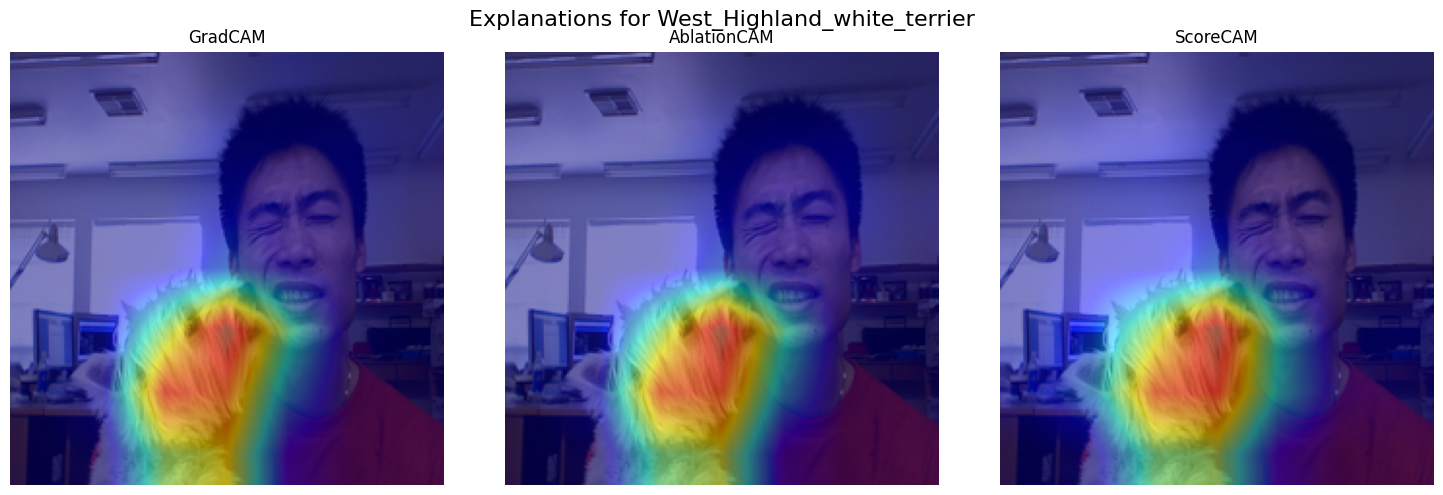


Processing American_coot...
Saved: outputs/American_coot_GradCAM.png


100%|██████████| 64/64 [03:42<00:00,  3.48s/it]


Saved: outputs/American_coot_AblationCAM.png


100%|██████████| 128/128 [02:45<00:00,  1.29s/it]


Saved: outputs/American_coot_ScoreCAM.png


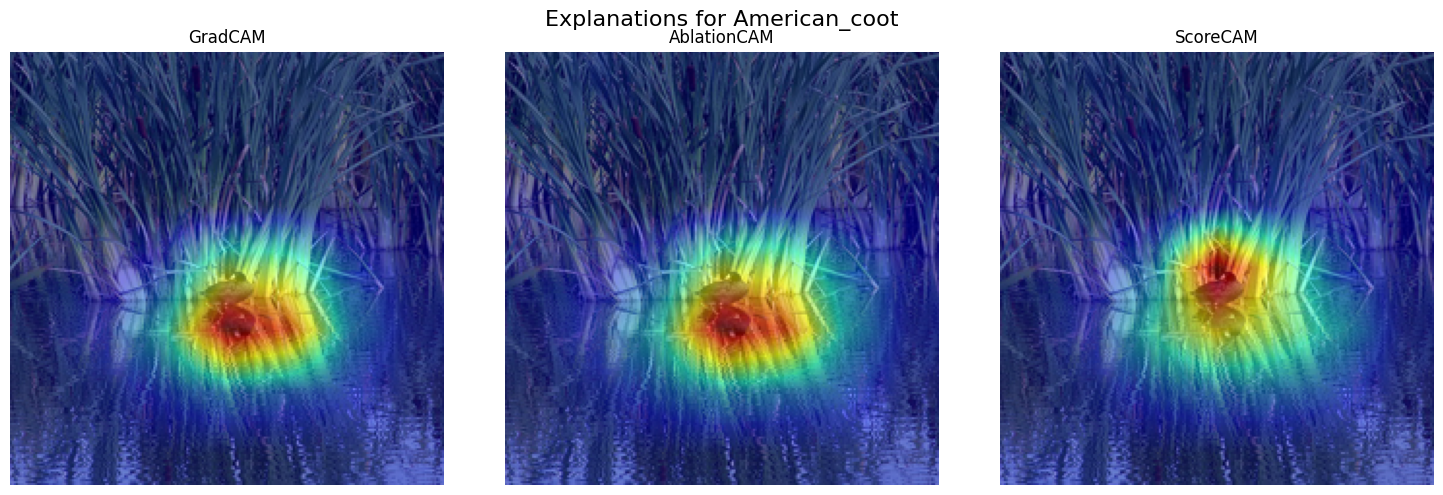


Processing racer...
Saved: outputs/racer_GradCAM.png


100%|██████████| 64/64 [03:40<00:00,  3.45s/it]


Saved: outputs/racer_AblationCAM.png


100%|██████████| 128/128 [02:33<00:00,  1.20s/it]


Saved: outputs/racer_ScoreCAM.png


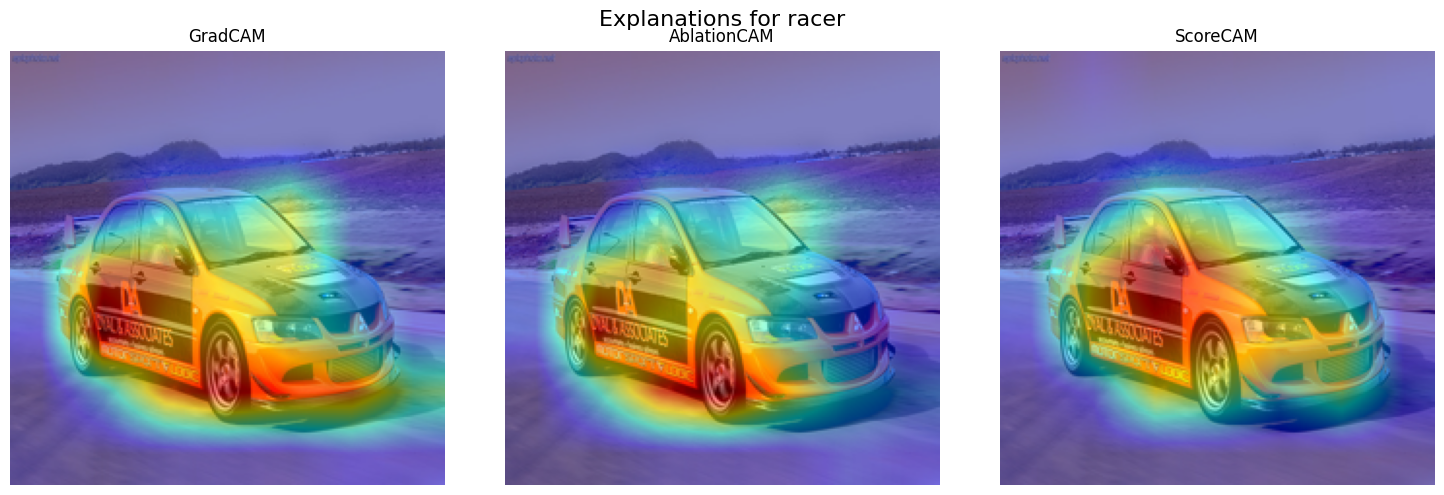


Processing flamingo...
Saved: outputs/flamingo_GradCAM.png


100%|██████████| 64/64 [03:40<00:00,  3.45s/it]


Saved: outputs/flamingo_AblationCAM.png


100%|██████████| 128/128 [02:46<00:00,  1.30s/it]


Saved: outputs/flamingo_ScoreCAM.png


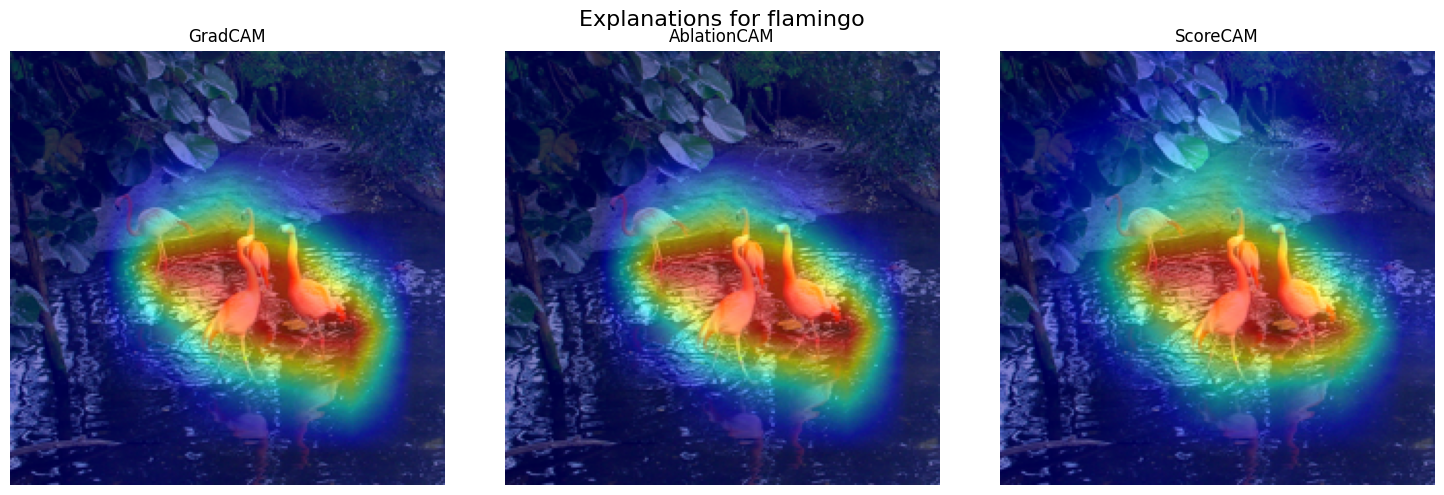


Processing kite...
Saved: outputs/kite_GradCAM.png


100%|██████████| 64/64 [03:42<00:00,  3.48s/it]


Saved: outputs/kite_AblationCAM.png


100%|██████████| 128/128 [02:43<00:00,  1.28s/it]


Saved: outputs/kite_ScoreCAM.png


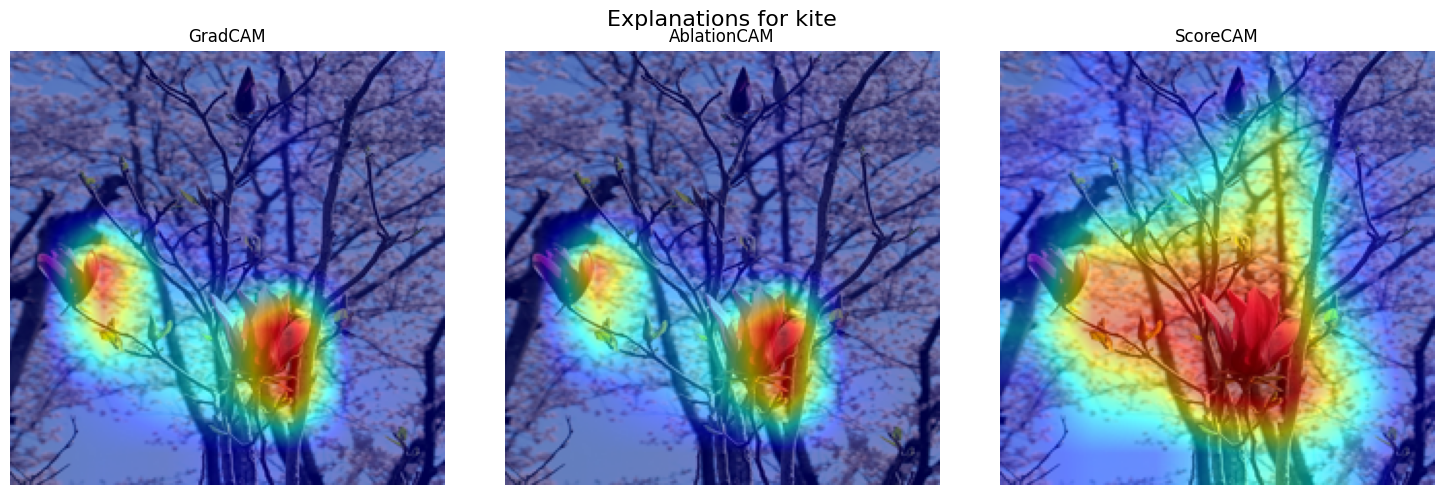


Processing goldfish...
Saved: outputs/goldfish_GradCAM.png


100%|██████████| 64/64 [03:41<00:00,  3.46s/it]


Saved: outputs/goldfish_AblationCAM.png


100%|██████████| 128/128 [02:46<00:00,  1.30s/it]


Saved: outputs/goldfish_ScoreCAM.png


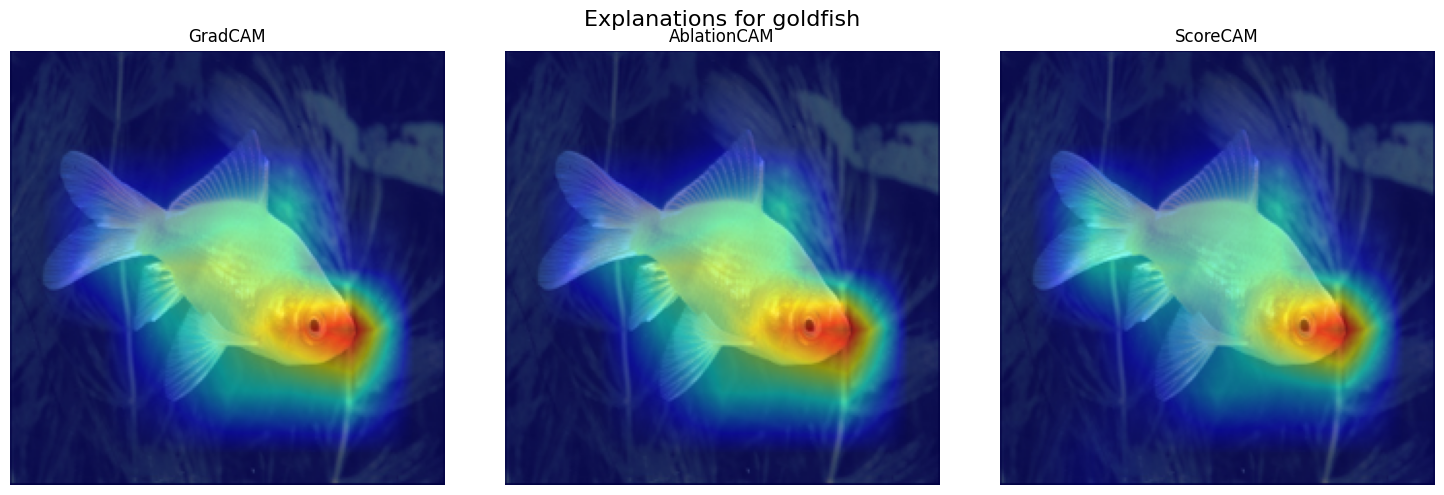


Processing tiger_shark...
Saved: outputs/tiger_shark_GradCAM.png


100%|██████████| 64/64 [03:47<00:00,  3.56s/it]


Saved: outputs/tiger_shark_AblationCAM.png


100%|██████████| 128/128 [02:42<00:00,  1.27s/it]


Saved: outputs/tiger_shark_ScoreCAM.png


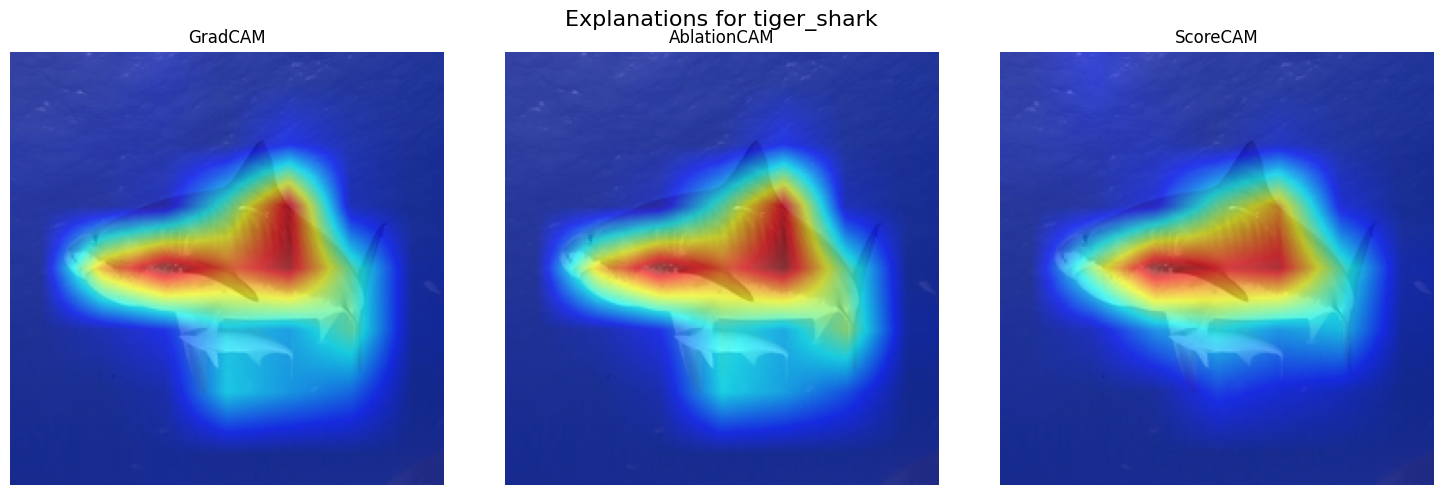


Processing vulture...
Saved: outputs/vulture_GradCAM.png


100%|██████████| 64/64 [02:46<00:00,  2.60s/it]


Saved: outputs/vulture_AblationCAM.png


100%|██████████| 128/128 [01:45<00:00,  1.21it/s]


Saved: outputs/vulture_ScoreCAM.png


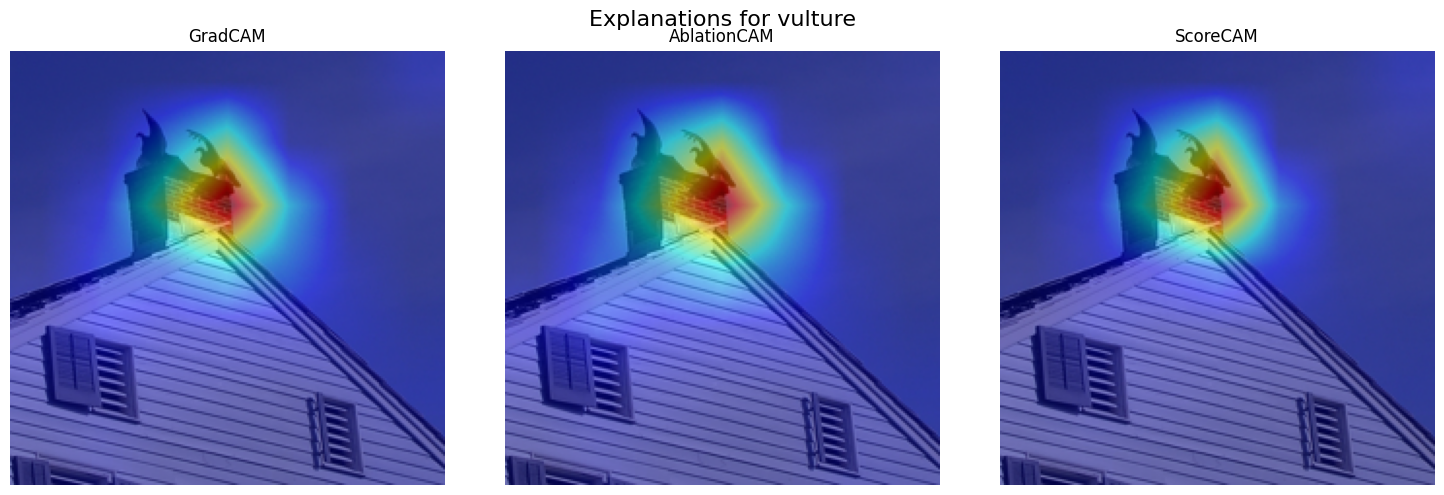


Processing common_iguana...
Saved: outputs/common_iguana_GradCAM.png


100%|██████████| 64/64 [01:46<00:00,  1.67s/it]


Saved: outputs/common_iguana_AblationCAM.png


100%|██████████| 128/128 [01:44<00:00,  1.22it/s]


Saved: outputs/common_iguana_ScoreCAM.png


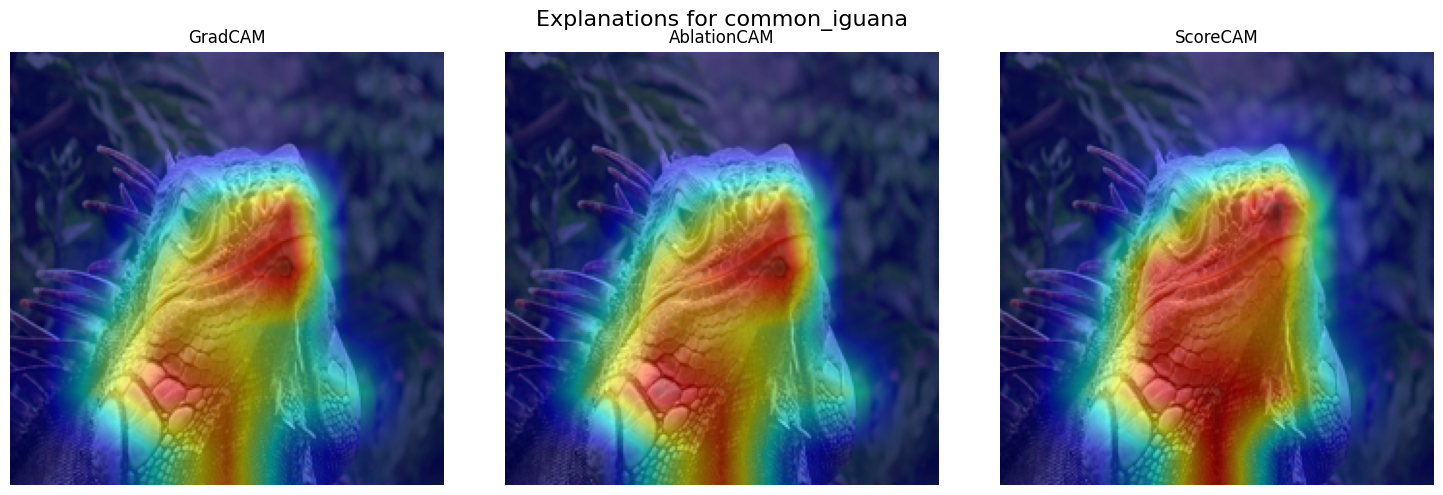


Processing orange...
Saved: outputs/orange_GradCAM.png


100%|██████████| 64/64 [01:46<00:00,  1.66s/it]


Saved: outputs/orange_AblationCAM.png


100%|██████████| 128/128 [01:45<00:00,  1.21it/s]


Saved: outputs/orange_ScoreCAM.png


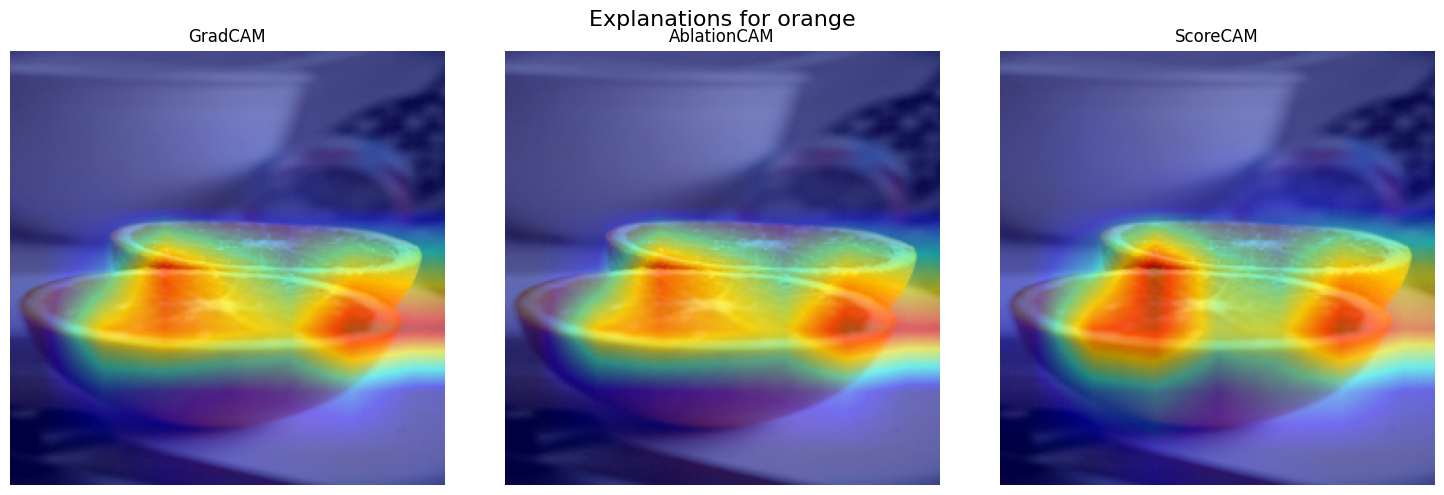

In [7]:
# -------- Step 5: Generate Heatmaps and Save -------- #
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

for name in image_urls:
    print(f"\nProcessing {name}...")
    img_path = f"images/{name}.jpeg"
    img, tensor, raw = preprocess(img_path)

    with torch.no_grad():
        pred = model(tensor)
        class_id = pred.argmax().item()

    # Prepare grid to show all CAMs
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Explanations for {name}", fontsize=16)
    
    for i, (method_name, cam) in enumerate(cam_methods.items()):
        grayscale_cam = cam(input_tensor=tensor, targets=[ClassifierOutputTarget(class_id)])[0]
        heatmap = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
        # Save image
        save_path = f"{output_dir}/{name}_{method_name}.png"
        cv2.imwrite(save_path, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
        print(f"Saved: {save_path}")
    
        # Plot in grid
        axs[i].imshow(heatmap)
        axs[i].set_title(method_name)
        axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()
